# SLM calibration

This file is used to generate , display and measure grayscale images for calibrating the phase shift of a phase SLM.

The SLM has a resolution of 800x600 px, each 32x32um^2 with a fill factor of 85%

In [30]:
from ximea import xiapi
import matplotlib.pyplot as plt
import numpy as np


## Image acquisition example

In [ ]:
#CIMAU2430046
cam = xiapi.Camera(0)
print("Opening camera...")
cam.open_device_by_SN('CIMAU2430046')
width = cam.get_width()
height = cam.get_height()
print("Camera open (if it worked)")

Opening camera...


Sensor bit depth:  XI_BPP_12
Starting data acquisition...


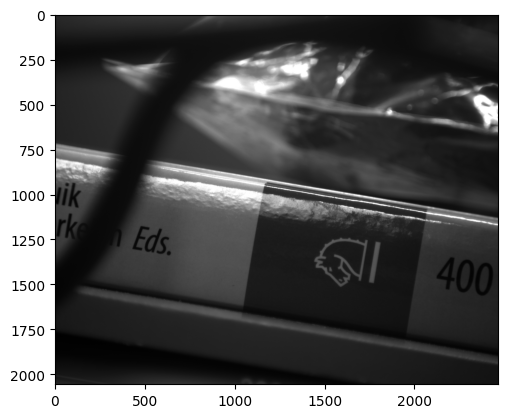

In [38]:
sensor_bit_depth = cam.set_sensor_bit_depth('XI_BPP_12')
sensor_bit_depth = cam.get_sensor_bit_depth()
print('Sensor bit depth: ', sensor_bit_depth)
cam.set_gain(0) 
cam.set_exposure(20000)
img = xiapi.Image()
print('Starting data acquisition...')
cam.start_acquisition()
cam.get_image(img)
data_raw = img.get_image_data_raw()
data = list(data_raw)

cam.stop_acquisition()

npdata = np.reshape(data,(height, width))

plt.imshow(npdata,cmap ='grey')
plt.show()

In [32]:
cam.close_device()
